# Анализ кластеров за 2016 год

In [1]:
import json
import numpy as np
from itertools import groupby
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import datetime
from matplotlib.dates import MO
from random import shuffle

%matplotlib notebook

In [2]:
class News:
    def __init__(self, id, date, title, content, url, siteType):
        self.id = id
        self.date = date
        self.title = title
        self.content = content
        self.url = url
        self.siteType = siteType
    
    @classmethod
    def from_json(cls, json_str):
        json_dict = json.loads(json_str)
        return cls(**json_dict)

In [3]:
def filter_words(text):
    words_list = text.split()
    newWords = [x for x in words_list if len(x) > 3]
    return " ".join(newWords)

# Загрузка новостей

In [4]:
news = []
with open('/data/kasandra/year/2016.all.normalized.json', encoding="utf8") as f:
    for line in f:
        news.append(News.from_json(line))
news_map = {n.id: n for n in news}

# Удаление стоп-слов

In [5]:
words = []
for n in news:
    words.extend(n.content.split())
counts = Counter(words)
one_time = [k for k, v in dict(counts).items() if v == 1]
print("total words: %s" % (len(words) - len(one_time)))

total words: 19048075


In [6]:
one_time_words = set(one_time)

# Загрузка результатов кластеризации

In [7]:
news_labels = {}
with open('/data/kasandra/year/result/2016.300.kmeans.json', encoding="utf8") as f:
    news_labels = json.loads(f.read())

In [8]:
cluster_news = {}
for n_id, label in news_labels.items():
    if label in cluster_news:
        n_list = cluster_news[label]
        n_list.append(news_map[n_id])
    else:
        n_list = []
        n_list.append(news_map[n_id])
        cluster_news[label] = n_list

# Векторизация

In [9]:
news_constent = [filter_words(x.content) for x in news]

In [10]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, tokenizer=lambda text: text.split(" "), stop_words=one_time_words,
                                   max_df=0.5, min_df=2, norm='l2')

tfidf_matrix = tfidf_vectorizer.fit_transform(news_constent)
print("vocabulary size: %s" % len(tfidf_vectorizer.vocabulary_))

vocabulary size: 95475


# Количество новостей в кластерах

In [11]:
counts = Counter(news_labels.values())
counts.most_common(300)

[(21, 7121),
 (47, 1974),
 (38, 1368),
 (102, 1222),
 (67, 1144),
 (280, 1142),
 (10, 1024),
 (238, 966),
 (157, 950),
 (24, 922),
 (164, 891),
 (214, 876),
 (95, 874),
 (253, 874),
 (207, 849),
 (276, 823),
 (211, 775),
 (69, 759),
 (28, 754),
 (261, 737),
 (54, 723),
 (267, 712),
 (188, 708),
 (137, 705),
 (16, 694),
 (44, 688),
 (7, 681),
 (297, 675),
 (5, 654),
 (184, 654),
 (160, 619),
 (233, 616),
 (55, 614),
 (25, 612),
 (204, 603),
 (29, 589),
 (230, 571),
 (77, 550),
 (88, 548),
 (130, 544),
 (167, 544),
 (8, 529),
 (275, 518),
 (281, 514),
 (117, 511),
 (176, 510),
 (26, 508),
 (295, 505),
 (203, 504),
 (103, 500),
 (243, 497),
 (136, 493),
 (134, 491),
 (11, 486),
 (123, 483),
 (116, 481),
 (241, 474),
 (41, 471),
 (58, 469),
 (51, 465),
 (149, 455),
 (225, 451),
 (118, 450),
 (40, 447),
 (229, 444),
 (61, 439),
 (146, 437),
 (57, 434),
 (60, 434),
 (145, 428),
 (50, 422),
 (53, 422),
 (266, 401),
 (80, 399),
 (257, 393),
 (18, 389),
 (59, 383),
 (223, 380),
 (101, 379),
 (2

In [12]:
titles = [n.title for n in cluster_news[74]]
titles[:10]

['Президент Белоруссии Александр Лукашенко поддержал акцию паралимпийцев с российским флагом',
 'Паралимпийский комитет идентифицировал белорусского атлета, пронёсшего флаг РФ',
 'Меценатом, подарившим квартиру Андрею Фомочкину, оказался православный бизнесмен-автогонщик Сергей Шмаков',
 'Самое главное за ночь: российские хоккеисты обыграли чехов в товарищеском матче, а с Паралимпиады выгнали еще одного члена белорусской делегации',
 'IPC проведет расследование в отношении белорусов за вынос российского флага',
 'Захарова назвала героем белоруса, пронёсшего флаг РФ на Паралимпиаде',
 'Награда нашла героя: поднявший российский флаг в Рио белорус получил квартиру',
 'Самое главное за ночь: защита полковника Захарченко планирует обжаловать его арест, а Фомочкин хочет подарить российским паралимпийцам тот самый флаг',
 'Андрей Фомочкин: Телефон разрывался, не ожидал такой поддержки от россиян',
 'Белоруссия готова ответить за поступок Фомочкина, пронёсшего флаг России']

# Сегментирование кластеров по дням

In [13]:
# 2016
start_year = 1451595600 * 1000
end_year = 1483217999 * 1000 + 1
day_millis = 24 * 60 * 60 * 1000

## Сегментация с накапливанием

In [14]:
def segment_news_accumulation(seg_news):
    segmented_news = {}
    for start_day in range(start_year, end_year, day_millis):
        end_day = start_day + day_millis
        cur_news = [n for n in seg_news if n.date >= start_year and n.date < end_day]
        segmented_news[start_day] = cur_news
    return segmented_news

## Сегментация по конкретным дням

In [15]:
def segment_news_daily(seg_news):
    segmented_news = {}
    for start_day in range(start_year, end_year, day_millis):
        end_day = start_day + day_millis
        cur_news = [n for n in seg_news if n.date >= start_day and n.date < end_day]
        segmented_news[start_day] = cur_news
    return segmented_news

# Вычисление отклонений для кластера

In [16]:
# year_centrid = np.array(tfidf_matrix.mean(axis=0))[0]
year_centrid = np.empty(tfidf_matrix.shape[1])
year_centrid.fill(1)

In [17]:
def day_cos(day_news):
    cos_news = {}
    for day, d_news in day_news.items():
        if len(d_news) > 0:
            content_day = [filter_words(x.content) for x in d_news]
            tfidf_day = tfidf_vectorizer.transform(content_day)
            day_centroid = np.array(tfidf_day.mean(axis=0))[0]
            cos_news[day] = 1 - spatial.distance.cosine(year_centrid, day_centroid)
        else:
            cos_news[day] = 0
    return cos_news

# Отрисовка графика

In [18]:
def plot_cos_centroid(cos_days, start_day, end_day, label):
    # plt.rcParams['figure.figsize'] = (20.0, 8.0)
    # plt.rcParams['font.size'] = 12
    fig, ax = plt.subplots()

    myFmt = mdates.DateFormatter('%d.%m.%Y')
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))

    datemin = datetime.datetime.fromtimestamp(start_day/1000) - datetime.timedelta(days=7)
    datemax = datetime.datetime.fromtimestamp(end_day/1000) + datetime.timedelta(days=7)
    ax.set_xlim(datemin, datemax)
    
    x = []
    y = []
    
    sorted_dates = sorted(list(cos_days.keys()))
    
    for ddd in sorted_dates:
        x.append(datetime.datetime.fromtimestamp(ddd/1000))
        y.append(cos_days[ddd])

    ax.plot(x, y, label = label)
    ax.legend(loc='upper right')
    fig.autofmt_xdate(rotation=60)
    fig.show()

# Вывод N первых новостей из кластера

In [19]:
def print_news(cl_news, n, cl_label):
    rand_news = []
    rand_news.extend(cl_news)
    shuffle(rand_news)
    
    print("cluster: %s, %s из %s новостей:" %(cl_label, n, len(cl_news)))
    for nn in rand_news[:n]:
        print("\t %s" % nn.title)

# Отображение сегментов

In [20]:
def compute_for_cluster(segment_method, cl_news, cluster_number):
    segmented_news = segment_method(cl_news)
    cos_news = day_cos(segmented_news)
    
    print("График для кластера: %s" % (cluster_number))
    plot_cos_centroid(cos_news, start_year, end_year, cluster_number)
    print_news(cl_news, 10, cluster_number)
    print("----------------------")

# Фильтрация кластеров
убираем нулевой кластер и кластеры с маленьким количеством новостей

In [23]:
max_cluster_size = 700
mix_cluster_size = 670

In [24]:
medium_clusters = {k: v for k, v in cluster_news.items() if len(v) >= mix_cluster_size and len(v) <= max_cluster_size }
print("count clusters: %s" % len(medium_clusters))

count clusters: 4


# Графики

## Сегментация с накапливанием

График для кластера: 16


<IPython.core.display.Javascript object>


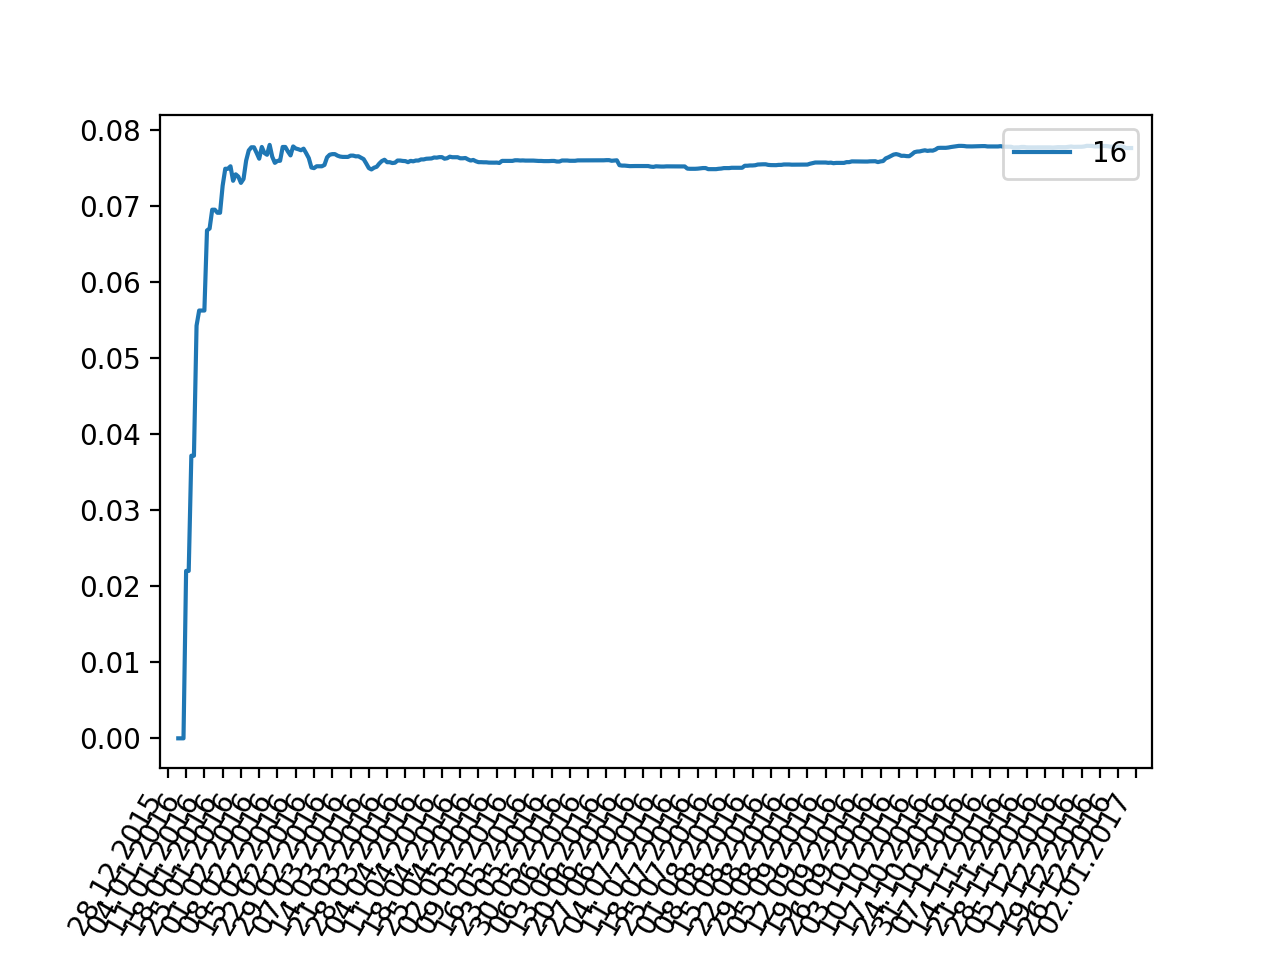

cluster: 16, 10 из 694 новостей:
	 Россия готова изучить предложения США по военному сотрудничеству в Сирии
	 Серж Саргсян: Армения выступает за скорейшее разрешение сирийской проблемы
	 Еще один игрок
	 США объяснили "секретность" договора с Россией по Сирии
	 Киселёв: американцы в Сирии не успевают и тормозят
	 Воюем год. Конца не видно
	 Захарова отреагировала на призыв Джонсона устроить протест у посольства России
	 ИГИЛ* до сих пор жив лишь благодаря США
	 Вице-президент США перепутал Асада и Хусейна
	 Рациональное число: какую технику и для чего оставила Россия в Сирии
----------------------
График для кластера: 297


<IPython.core.display.Javascript object>


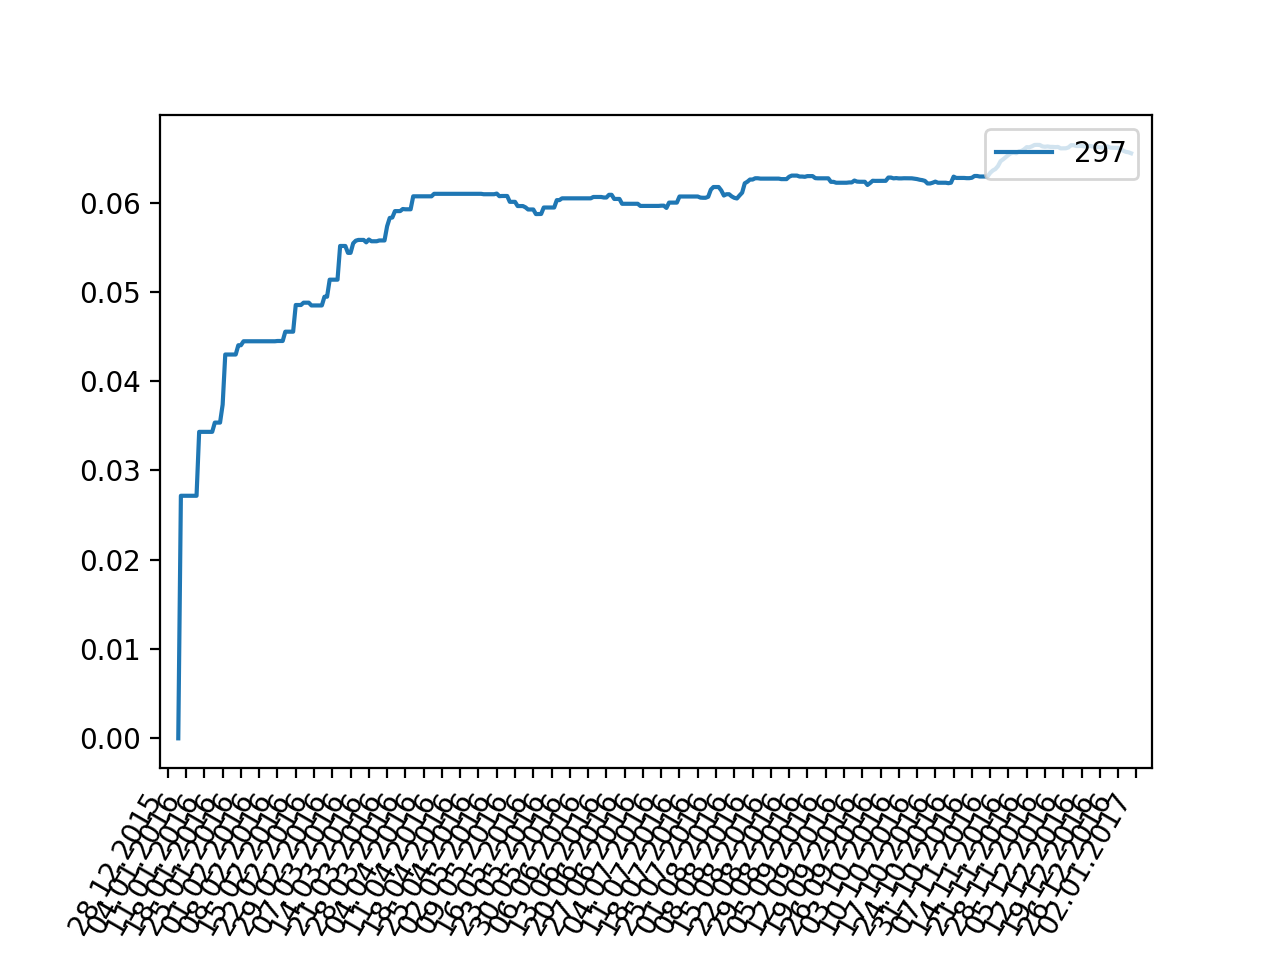

cluster: 297, 10 из 675 новостей:
	 СМИ: Спецслужбы хотят снять этаж в Trump Tower, чтобы охранять семью президента
	 CNN опубликовал новую порцию неоднозначных заявлений Трампа о женщинах
	 Модельер Мишель Обамы отказалась одевать Меланию Трамп
	 В Лондоне выставят голого Трампа
	 Трамп и Обама нашли общий язык: встреча затянулась на полтора часа
	 LA Times: Трамп требовал уволить из своего гольф-клуба всех некрасивых сотрудниц
	 Трамп обвинил Китай в "изнасиловании" США, а Обама показал хип-хоп
	 Ротшильды таки накрыли Америку и планету Трампом
	 Трамп сравнил ситуацию в экономике США с пузырем
	 Создатели "Симпсонов" жалеют, что их предсказание о победе Трампа сбылось
----------------------
График для кластера: 44


<IPython.core.display.Javascript object>


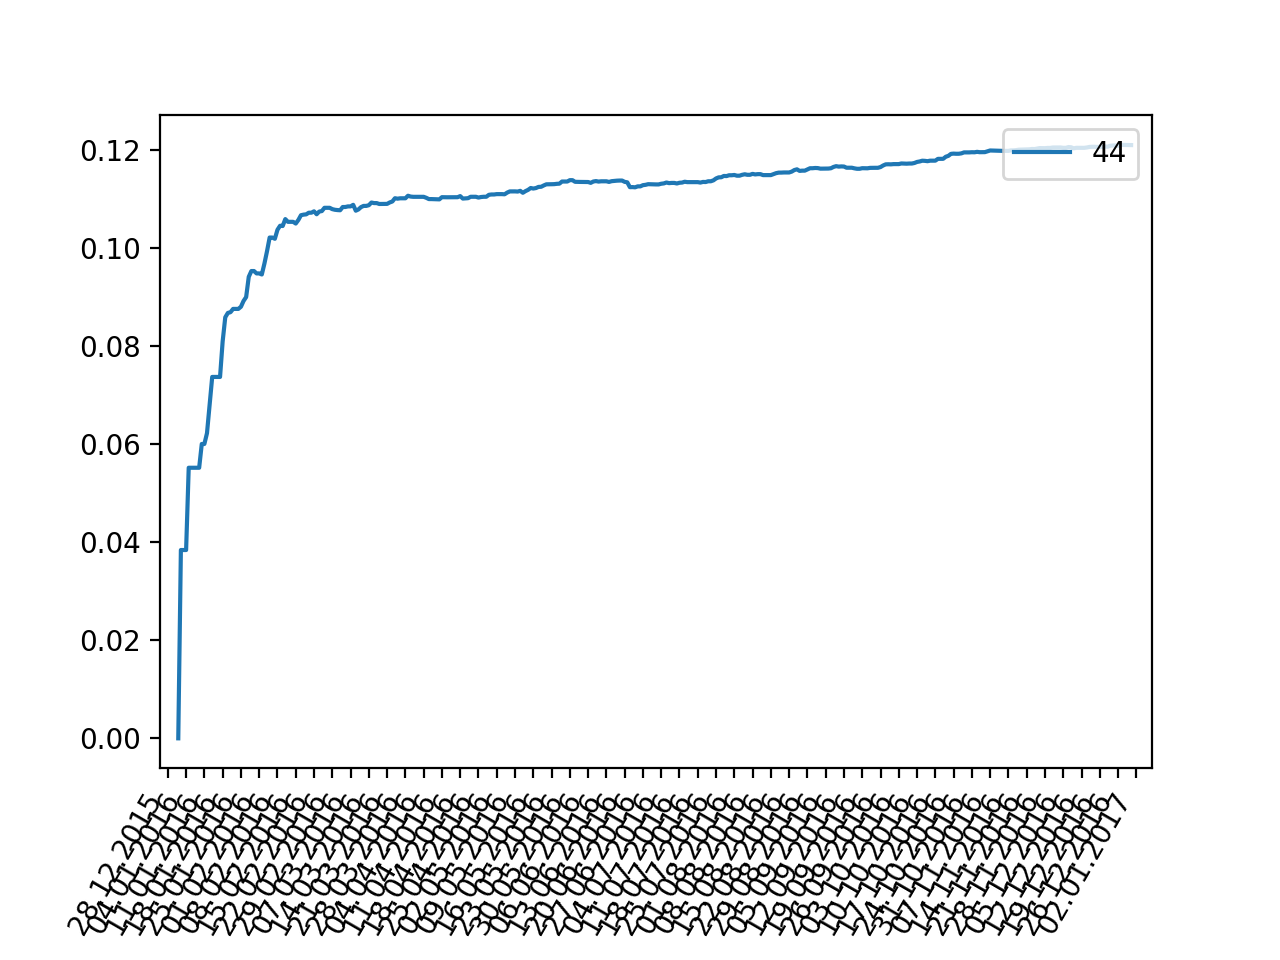

cluster: 44, 10 из 688 новостей:
	 Российские металлурги подпали под санкции Евросоюза
	 Бесплатные объявления в кризис: Поймаю покемона, одолжу злую кошку
	 Эффект принтера: почему «Почта России» остановила продажу некоторых марок
	 В России выросли продажи «борщевого набора»
	 Как это работает: сколько приносит производство «зеленой» бытовой химии
	 Рост цен в магазинах — результат экономической политики 90-х, считают в отрасли
	 Россия исключила из продуктового эмбарго мясо и овощи для детского питания
	 85 % школьных брюк опасно носить!
	 Bloomberg: Москва заработала на еде больше, чем на оружии
	 Самая большая в Заполярье рыбная фабрика начала работу в Мурманске
----------------------
График для кластера: 7


<IPython.core.display.Javascript object>


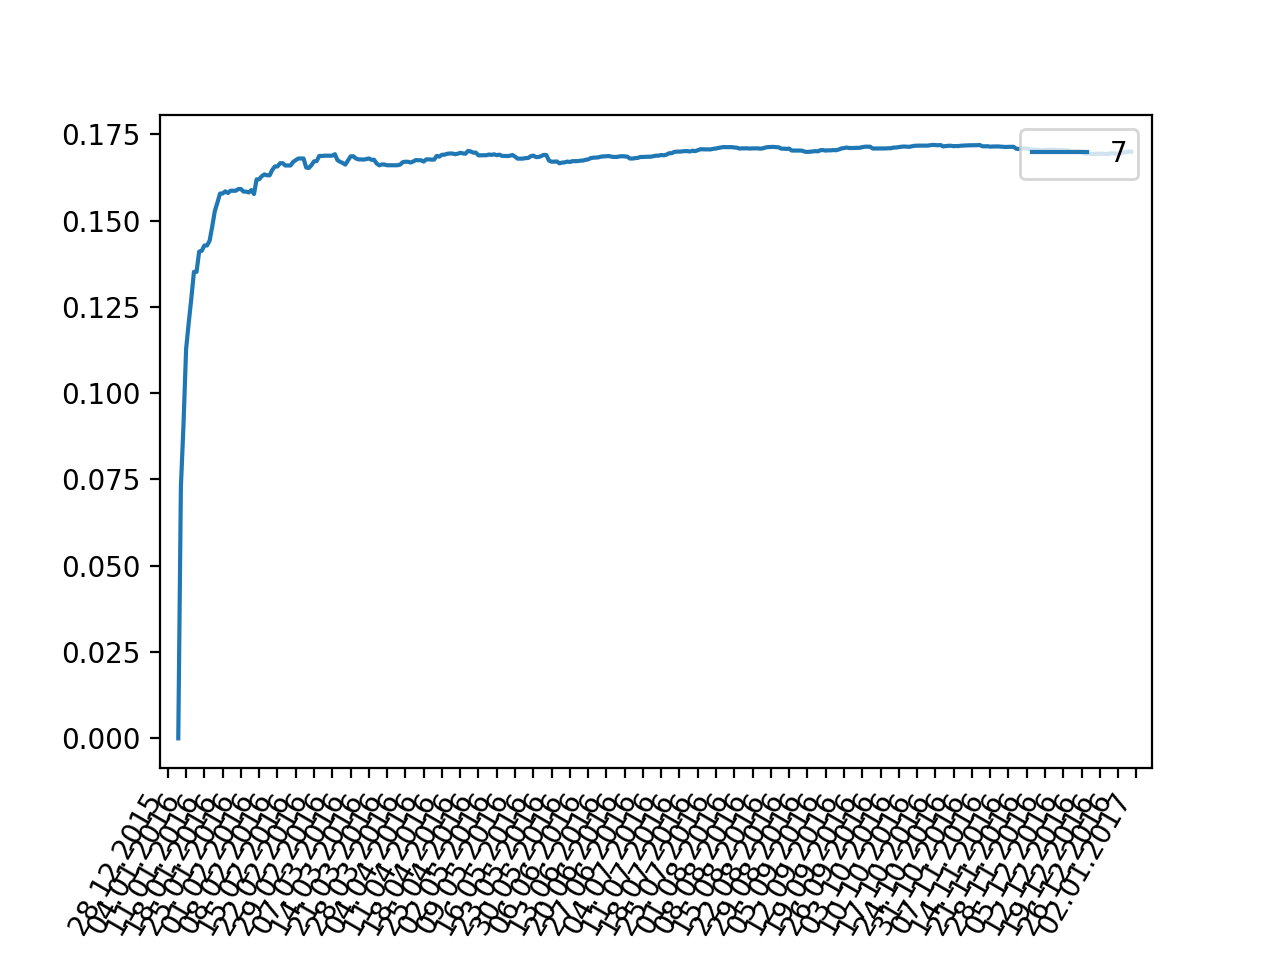

cluster: 7, 10 из 681 новостей:
	 Саратовские чиновники решили наградить мясорубками ветеранов битвы под Москвой
	 Период распада: последний декабрь Союза. 9 декабря 1991 года
	 «Неуклонно деградируют»
	 Стрельба по-черногорски: как Россия не совершила переворот на Балканах
	 Два года достоинства
	 Линия разрыва: почему Россия балансирует между демократией и технократией
	 Солдат Победы служит в МЧС
	 Между красными и зелеными
	 Александр Захарченко: Перед Новым годом у нас родились тройняшки. Их назвали... ДНР
	 Принять за образец
----------------------


In [25]:
for c_label, c_news in medium_clusters.items():
    compute_for_cluster(segment_news_accumulation, c_news, c_label)

## Сегментация по дням

График для кластера: 16


<IPython.core.display.Javascript object>


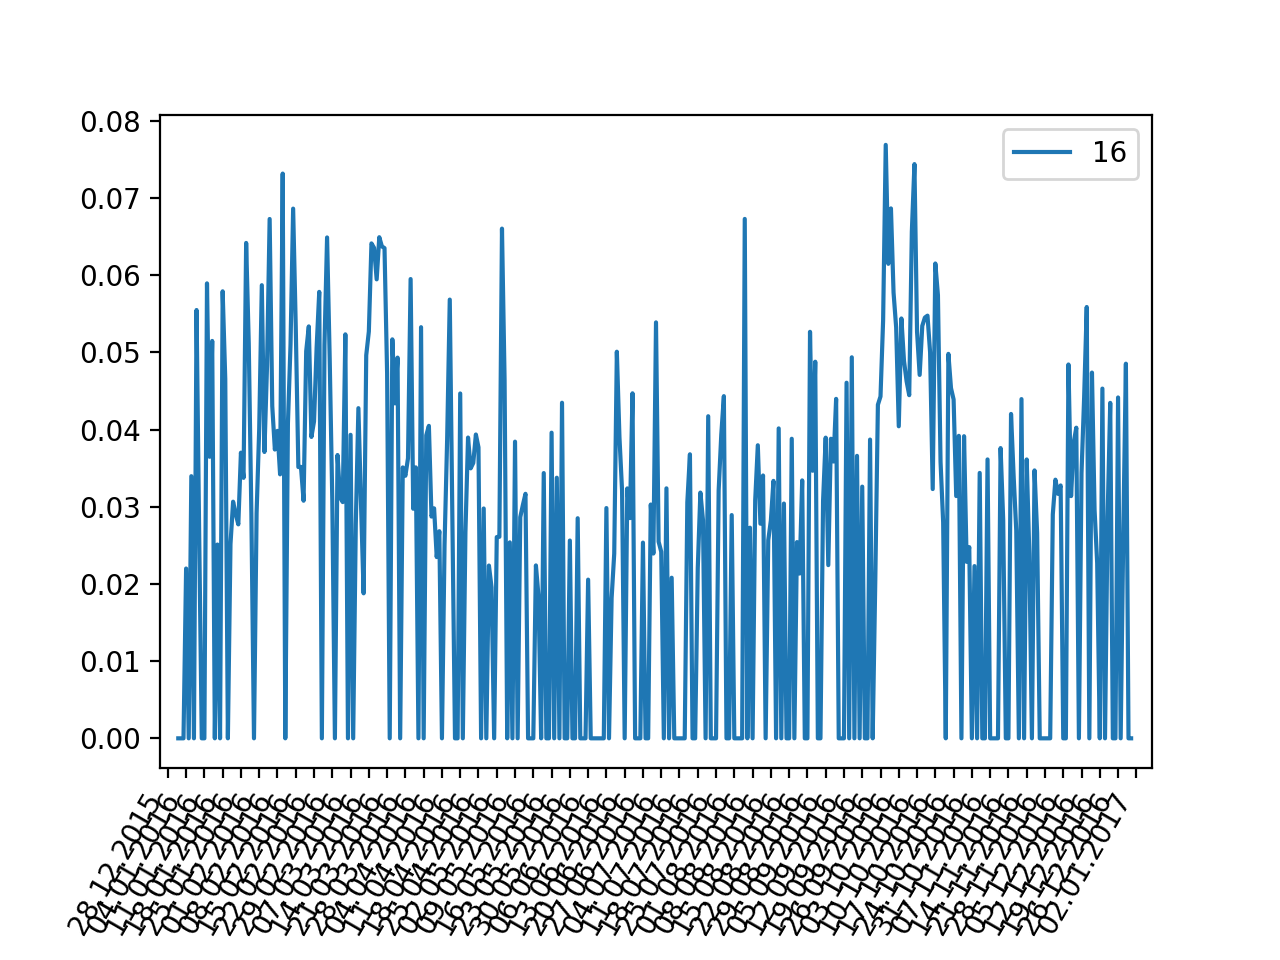

cluster: 16, 10 из 694 новостей:
	 Эксперт: Заявления Евросоюза по Сирии - это информационная кампания против России
	 Журналисты РЕН ТВ попали в осаду в Сирии
	 Владимир Путин: Задача, поставленная перед нашими вооруженными силами в Сирии, выполнена
	 В Женеве увидели перспективу прямых переговоров Дамаска и оппозиции
	 Россия хочет оставить боевиков без подпитки и добить
	 Минобороны РФ ответило на заявление Фэллона о действиях ВКС в Сирии
	 Большинство россиян поддержали продолжение войны в Сирии
	 Россия намерена создать военно-морскую базу в сирийском Тартусе
	 США не исключили возможности ударов по сирийской армии
	 В районе Хомса разбился российский вертолет Ми-28H
----------------------
График для кластера: 297


<IPython.core.display.Javascript object>


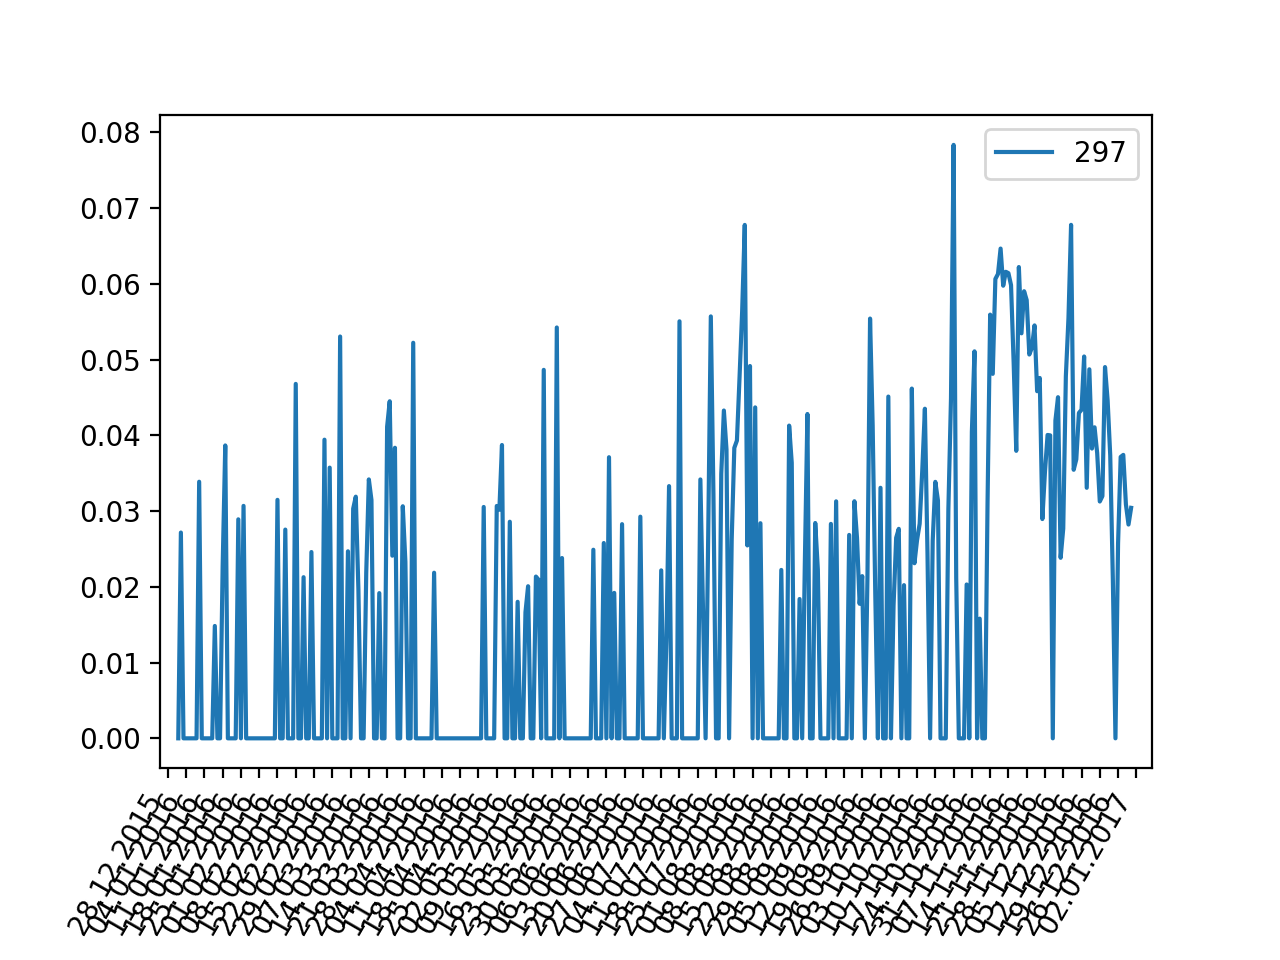

cluster: 297, 10 из 675 новостей:
	 Трамп рассказал, какими правилами будет руководствоваться его администрация
	 В серии «Симпсонов» нашли предсказание о крахе США после правления Трампа
	 Создатели "Симпсонов" жалеют, что их предсказание о победе Трампа сбылось
	 Трамп в первые 100 дней президентства: Рабочие места, отказ от медицины по-обамовски и депортация всех мигрантов из тюрем
	 Трамп подсчитал стоимость строительства стены на границе с Мексикой
	 Трамп даст показания против ресторатора, у которого хочет отсудить $10 млн
	 Провал американской демократии
	 В Китае поймали рыбу, похожую на Дональда Трампа
	 Трамп решил стать президентом после неудачной попытки купить футбольный клуб
	 Трамп назначил сотрудницу Fox News заместителем советника по нацбезопасности
----------------------
График для кластера: 44


<IPython.core.display.Javascript object>


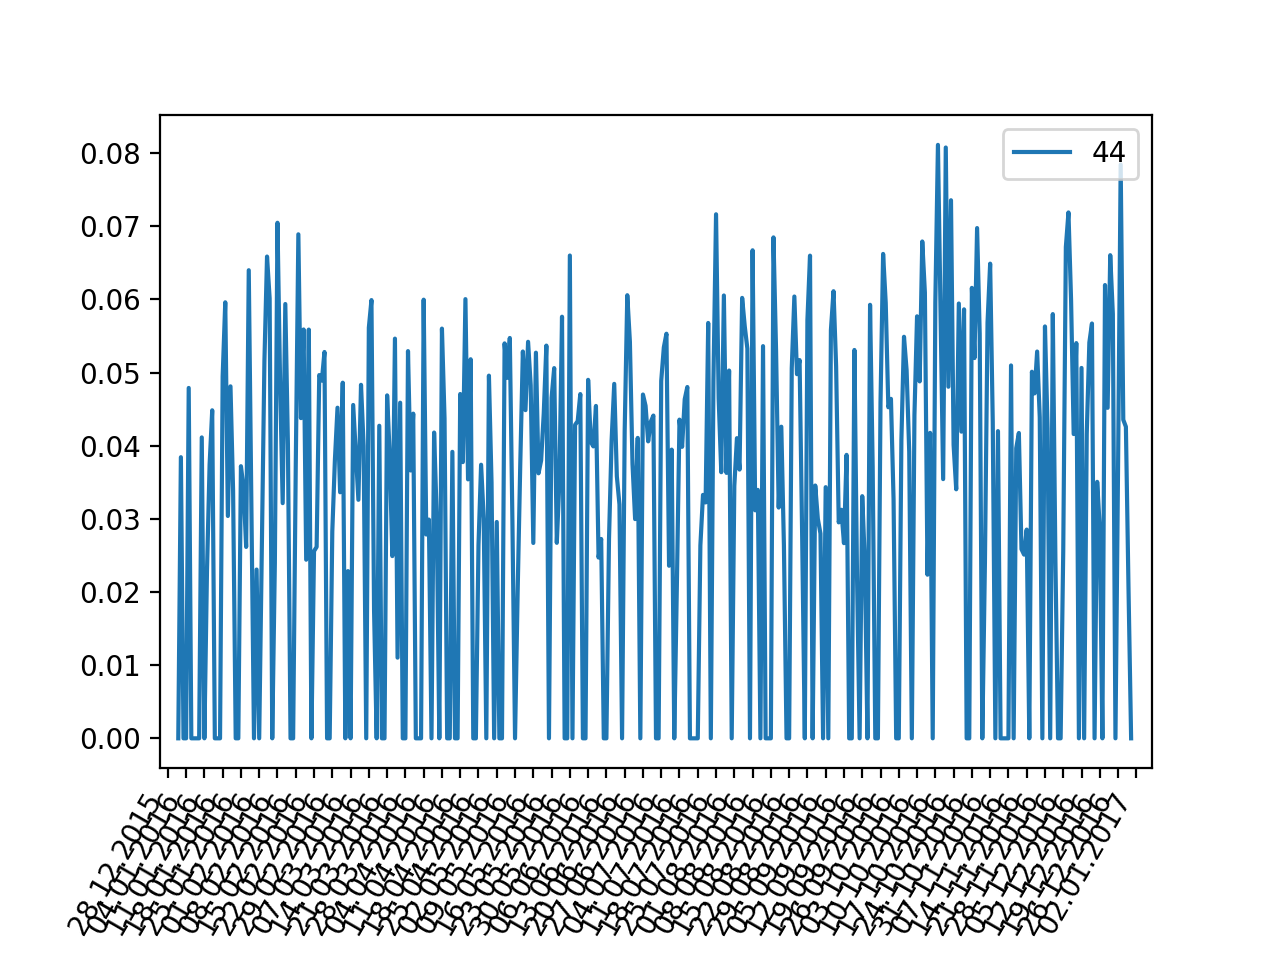

cluster: 44, 10 из 688 новостей:
	 Продавцов горючего творога привлекли к ответственности
	 Этим летом «Пятерочка» «вырастила» несколько новых универсамов!
	 «Коммерсантъ» узнал о возможных перебоях с поставками сигарет
	 Еда или имитация: пальмовое масло захватило почти четверть молочного рынка России
	 Украинский завод прекратил поставки в РФ жизненно важного лекарства
	 Крымская "Массандра" получит "географическую защиту"
	 Сальмонелла вприкуску
	 Спрос на майском «Киберпонедельнике» оказался ниже ожиданий
	 Подарок Медведеву вызвал дипломатический скандал между Испанией и Израилем
	 Минпромторг определил критерии для присвоения знака «Сделано в России»
----------------------
График для кластера: 7


<IPython.core.display.Javascript object>


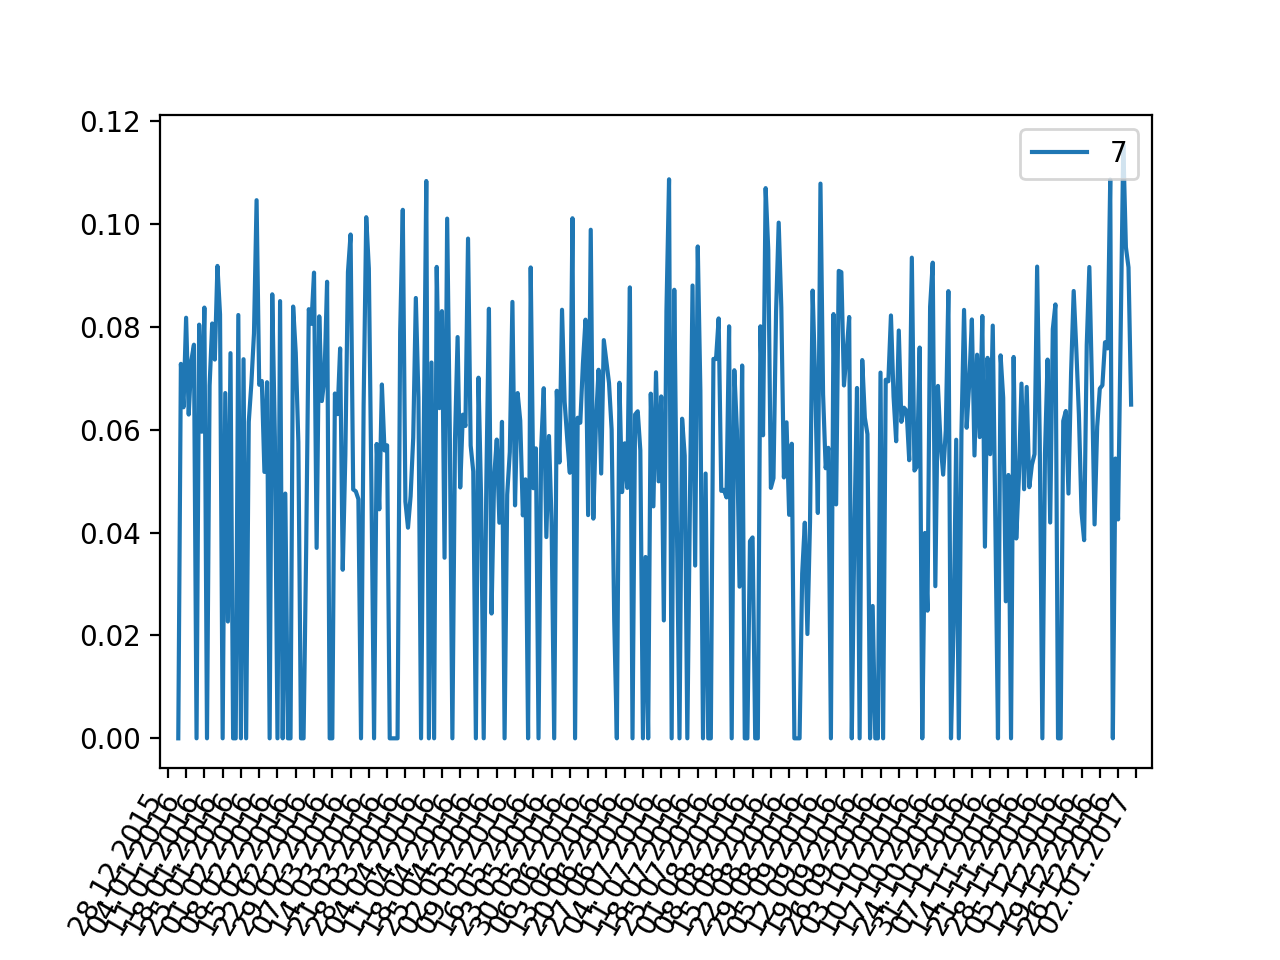

cluster: 7, 10 из 681 новостей:
	 От школьника до министра: русский язык набирает популярность в Венгрии
	 Призрак Воланда бродит по Европе. Реплика Георгия Бовта
	 22 июня 75 лет назад: траурные акции в День памяти и скорби прошли в городах России
	 Ретроградный марш
	 Николай I - первая жертва информационной войны Запада против России
	 80-летие Гражданской войны в Испании: уроки Западной Европы для Восточной
	 «Большевикам хотелось сблизиться с Европой»
	 Юбилей суперразведчика: Валентину Фалину - 90
	 Акция "Бессмертный полк" прошла в Мадриде
	 Август-91: был ли неизбежен распад СССР после провала путча?
----------------------


In [26]:
for c_label, c_news in medium_clusters.items():
    compute_for_cluster(segment_news_daily, c_news, c_label)